In [1]:
# %pip install auraloss


In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import json
from json import JSONEncoder
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Audio
from scipy import signal
from dtaidistance import dtw, similarity
import torchaudio
import auraloss # audio loss functions from steinmetz
import torchaudio.transforms as T

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# set random seed for reproducibility
# np.random.seed(1001)
# torch.manual_seed(0)

In [5]:
# For saving in RTNeural format
class EncodeTensor(JSONEncoder,Dataset):
    def default(self, obj):
        if isinstance(obj, torch.Tensor):
            return obj.cpu().detach().numpy().tolist()
        return super(json.NpEncoder, self).default(obj)

In [6]:
# The LSTM model based on RTNeural and GuitarML paper
class Model(torch.nn.Module):
    def __init__(self, hidden_size=8):
        super().__init__()
        self.lstm = torch.nn.LSTM(1, hidden_size, batch_first=False)
        self.dense = torch.nn.Linear(hidden_size, 1, bias=True)
        self.skip = 1

    def forward(self, torch_in):
        res = torch_in[:, :, 0:self.skip]
        x, _ = self.lstm(torch_in)
        x = self.dense(x)
        out = res + x # residual skip connection from input to output of LSTM layer 
        # out = x
        return out


In [7]:
# get max value over an interval
def max_tensor_over_interval(x, interval=1, sample_rate=44100):
    samples_per_segment = int(sample_rate * interval)
    num_segments = x.shape[1] // samples_per_segment  # Ensure integer division

    # Calculate the maximum sound level for each segment
    max_levels = torch.tensor([
        torch.max(torch.abs(x[:, i * samples_per_segment : (i + 1) * samples_per_segment]))
        for i in range(num_segments)
    ])
    return max_levels


In [8]:
# viz audio function
def viz_tensor_audio(x, interval=1, sample_rate=44100):
 
    max_levels = max_tensor_over_interval(x, interval, sample_rate)
    num_segments = max_levels.shape[0]
    
    # Plotting
    seconds = torch.arange(0, num_segments) * interval
    plt.figure(figsize=(10, 4))
    plt.plot(seconds, max_levels, marker='o')
    plt.xlabel('Time (s)')
    plt.ylabel('Max Amplitude')
    plt.title(f'Maximum Sound Level per {interval:.1f}s Segment')
    plt.grid(True)
    plt.show()


Input size torch.Size([1, 152345])
Target size torch.Size([1, 152345])
Sample rate 44100
Total seconds of audio 3.4545351473922903
Input audio


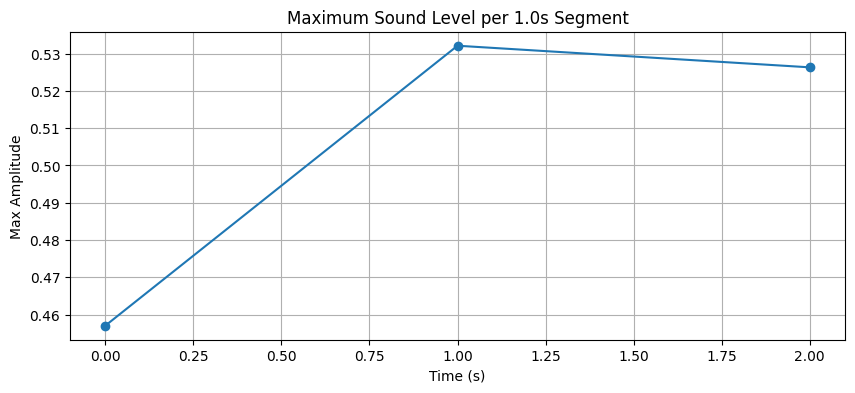

Target audio


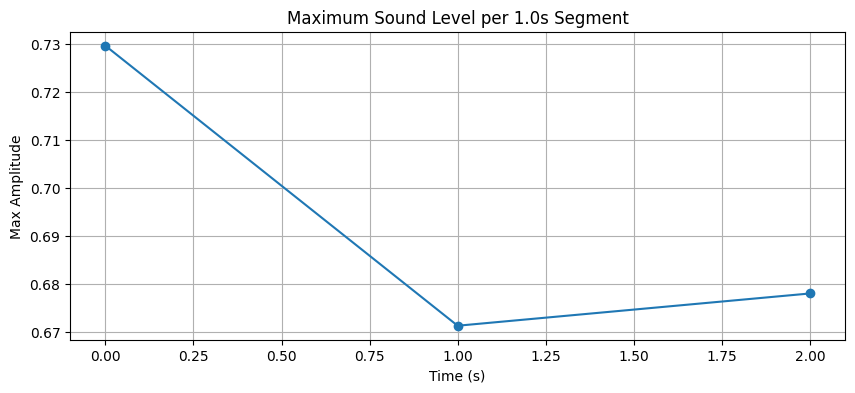

In [9]:
# Let's load the audio file
audio_x_file = './audio/ht1-input_test.wav'
# audio_x_file = './audio/ht1-input_train.wav'
audio_y_file = './audio/ht1-target_test.wav'
# audio_y_file = './audio/ht1-target_train.wav'
x, sample_rate = torchaudio.load(audio_x_file)
y_gold, _ = torchaudio.load(audio_y_file)

REDUCE = 11
#let's cut down the sample by REDUCE factor
length = x.shape[1] // REDUCE
x = x[:, 2*sample_rate:length]
y_gold = y_gold[:, 2*sample_rate:length]

print("Input size", x.shape)
print("Target size", y_gold.shape)
print("Sample rate", sample_rate)
print("Total seconds of audio", x.shape[1]/sample_rate)

print("Input audio")
display(Audio(x.squeeze().numpy(), rate=sample_rate))
viz_tensor_audio(x, interval=1.0, sample_rate=sample_rate)
print("Target audio")
display(Audio(y_gold.squeeze().numpy(), rate=sample_rate))
viz_tensor_audio(y_gold, interval=1.0, sample_rate=sample_rate)



y_pred_raw shape torch.Size([1, 152345, 1])
Untrained model output


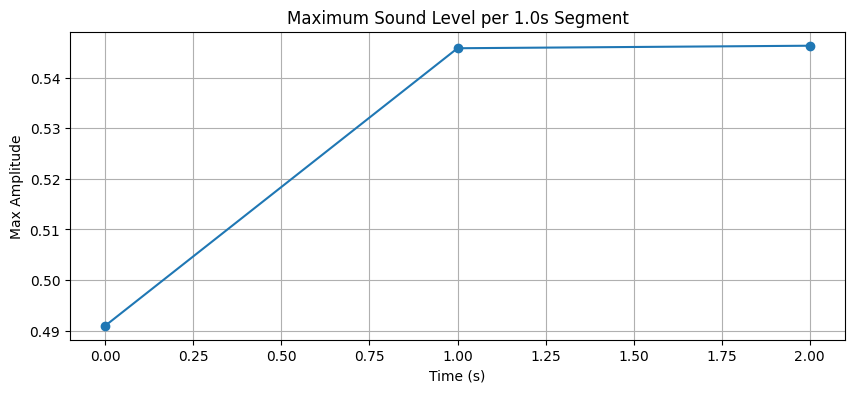

In [10]:
# without any training
x_tensor = x[0].reshape(1, -1, 1).to(device)
model_raw = Model().to(device)
model_raw.eval()
with torch.no_grad():
    y_pred_raw = model_raw.forward(x_tensor).detach()
print("y_pred_raw shape", np.shape(y_pred_raw))

print("Untrained model output")
display(Audio(y_pred_raw.squeeze().cpu().numpy(), rate=sample_rate))
viz_tensor_audio(y_pred_raw)


In [14]:
#normalize or no?
NORMALIZE = False
x_tensor = x[0].reshape(-1, 1, 1).to(device) # Shape: [N, L, Features]
y_gold_tensor = y_gold[0].reshape(-1, 1, 1).to(device)  # Must match x_tensor's shape
print("Input size", x_tensor.shape)
print("Target size", y_gold_tensor.shape)
if NORMALIZE:
    x_tensor_norm = x_tensor / torch.max(torch.abs(x_tensor))
    y_gold_tensor_norm = y_gold_tensor / torch.max(torch.abs(y_gold_tensor))
else:
    x_tensor_norm = x_tensor
    y_gold_tensor_norm = y_gold_tensor

if NORMALIZE:
    print("Normalized input size", x_tensor.shape)
    print("Normalized target size", y_gold_tensor.shape)
    plt.plot(x_tensor_norm.squeeze().cpu().numpy())
    plt.plot(x_tensor.squeeze().cpu().numpy())
    plt.legend(["Normalized", "Original"])
    plt.title("Normalized input")
    plt.show()
    plt.plot(y_gold_tensor_norm.squeeze().cpu().numpy())
    plt.plot(y_gold_tensor.squeeze().cpu().numpy())
    plt.legend(["Normalized", "Original"])
    plt.title("Normalized target")
    plt.show()

Input size torch.Size([152345, 1, 1])
Target size torch.Size([152345, 1, 1])


In [26]:
# Filter? Found this at blackboxRNNmodel
# https://github.com/arvidfalch/blackboxRNNmodeling/blob/main/main_training.ipynb
# Wether to filter the audio
filtered = False
dry = x_tensor_norm.squeeze().cpu().numpy()
wet = y_gold_tensor_norm.squeeze().cpu().numpy()

# Creating a high pass filter 
numtaps = 91
cutoff = 0.015
b = signal.firwin(numtaps, cutoff, width=None, window='hann', pass_zero='highpass')

# Creating a lowpass filter
numtaps = 41
cutoff = 0.92
b2 = signal.firwin(numtaps, cutoff, width=None, window='hann', pass_zero='lowpass')

#  high pass audio to emphasize high frequency information, low pass to avoid aliasing artifacts
# High Pass Filter
dry = signal.lfilter(b, 1, dry)
wet = signal.lfilter(b, 1, wet)
# Low Pass Filter
dry = signal.lfilter(b2, 1, dry)
wet = signal.lfilter(b2, 1, wet)

print("Normalized input")
display(Audio(x_tensor_norm.squeeze().cpu().numpy(), rate=sample_rate))
print("Filtered input")
display(Audio(dry, rate=sample_rate))
print("Normalized target")
display(Audio(y_gold_tensor_norm.squeeze().cpu().numpy(), rate=sample_rate))
print("Filtered target")
display(Audio(wet, rate=sample_rate))

if filtered is True:
    x_tensor_norm = torch.tensor(dry).reshape(1, -1, 1).to(device)
    y_gold_tensor_norm = torch.tensor(wet).reshape(1, -1, 1).to(device)


Normalized input


Filtered input


Normalized target


Filtered target


In [37]:
batch_size = sample_rate // 10  
# batch_size = 1
patience = 10
hidden_size = 64
eps = 1e-5
NUM_EPOCHS = 1000
lr = 0.001 # not so crazy high learning rate

dataset = TensorDataset(x_tensor_norm, y_gold_tensor_norm)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
torch.cuda.empty_cache()

# Model, loss function, optimizer, and scheduler setup
model = Model(hidden_size=hidden_size).to(device)
criterion = nn.MSELoss() # plain vanilla mean squared error
# criterion = auraloss.time.ESRLoss() # this goes backwards! something is wrong!!!!
# criterion = auraloss.freq.MultiResolutionSTFTLoss() # and this gives some padding error I don't understand
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1, min_lr=.001)

# Training loop
model.train()
cur_loss = 10000  # Initialize with a high value
patience_counter = 0  # Initialize patience counter
predictions = []  # To store predictions once per epoch
losses = []  # To store losses once per epoch

show_tqdm = False  # Set to True to show tqdm progress bar
for epoch in range(NUM_EPOCHS):
    epoch_losses = []  # Reset epoch losses for this epoch
    with tqdm(dataloader, disable=not show_tqdm, unit="batch", leave=True, position=0, desc=f"Epoch {epoch}") as tepoch:
        for batch_x, batch_y in tepoch:
            optimizer.zero_grad()
            y_pred = model(batch_x)
            loss = criterion(y_pred, batch_y)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) # Gradient Clipping
            optimizer.step()
            epoch_losses.append(loss.item()) # Collect loss for this batch
            tepoch.set_postfix(loss=loss.item()) # Update the tqdm postfix to show the loss value
    avg_loss = torch.mean(torch.tensor(epoch_losses)) # Compute average loss for the epoch

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients for evaluation
        full_pred = model(x_tensor).detach().squeeze().cpu().numpy()  # Get predictions for the full set
        predictions.append(full_pred)  # Append the predictions for this epoch
    losses.append(avg_loss.item())
    model.train()  # Set the model back to training mode

    scheduler.step(avg_loss)  # Perform scheduler step with the average loss

    # Early stopping with patience
    if abs(cur_loss - avg_loss.item()) < eps and cur_loss < .001:
        patience_counter += 1
        print(f'Epoch {epoch}, Loss: {avg_loss.item()}, Patience: {patience_counter}')
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}, Loss: {avg_loss.item()}')
            break
    else:
        patience_counter = 0  # Reset patience counter if loss improved

    cur_loss = avg_loss.item()

    # Print average loss every x epochs
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Average Loss: {avg_loss.item()}, lr = {scheduler.get_last_lr()}')

print(f'Final loss: {avg_loss.item()}')

RuntimeError: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (512, 512) at dimension 2 of input [1, 4410, 1]

In [11]:
# old trainer
# # Let's train!
# NUM_EPOCHS = 1000
# hidden_size=96
# eps = 0.00001
# lr = 0.1
# model = Model(hidden_size=hidden_size).to(device)
# criterion = torch.nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)

# x_tensor = x[0].reshape(1, -1, 1).to(device)
# y_gold_tensor = y_gold[0].reshape(1, -1, 1).to(device)

# losses = []  # to store loss values
# predictions = []  # to store predictions
# torch.cuda.empty_cache()
# model.train()
# epochs = NUM_EPOCHS  # set the number of epochs
# cur_loss = 1000
# for epoch in tqdm(range(epochs)):
#     optimizer.zero_grad()
#     y_pred = model(x_tensor)
#     loss = criterion(y_pred, y_gold_tensor)
#     loss.backward()
#     optimizer.step()
#     predictions.append(y_pred.detach())  # Saving predictions
#     losses.append(loss.item())

  
#     # early stop when loss doesn't change by more than eps
#     if cur_loss < .005 and abs(cur_loss - loss.item()) < eps:
#         print(f'Epoch {epoch}, Loss: {loss.item()}')
#         break

#     cur_loss = loss.item()
#     #  Print loss every 100 epochs
#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}, Loss: {loss.item()}')

In [13]:
save = True

if save == True:
    torch.save(model.state_dict(), f'lstm_torch_real_{hidden_size}.pth')
    # np.savetxt('lstm_torch_x_python.csv', x, delimiter=',')
    # np.savetxt('lstm_torch_y_python.csv', y_pred_1d, delimiter=',')

    with open(f'lstm_torch_real_{hidden_size}.json', 'w') as json_file:
        json.dump(model.state_dict(), json_file,cls=EncodeTensor)


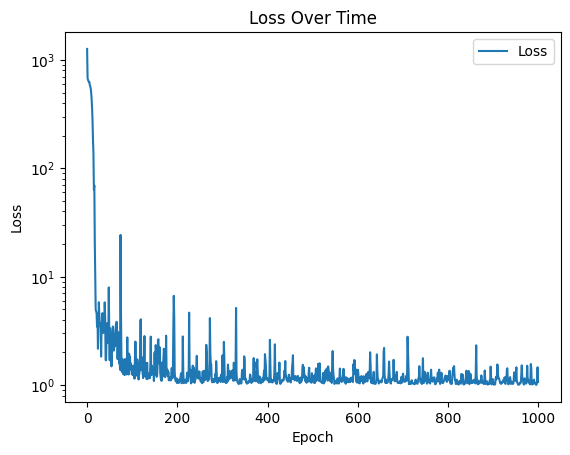

In [32]:
# Plotting the loss
plt.plot(np.arange(len(losses)), losses, label='Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

torch.Size([1, 152345])
torch.Size([1, 152345])
Gold audio


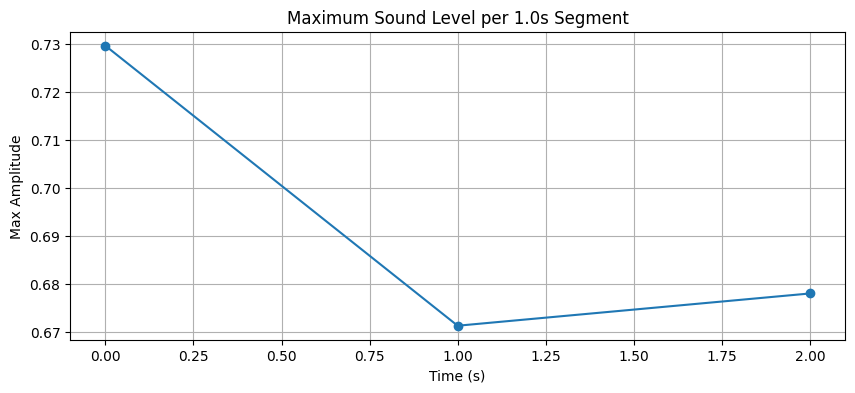

Output audio


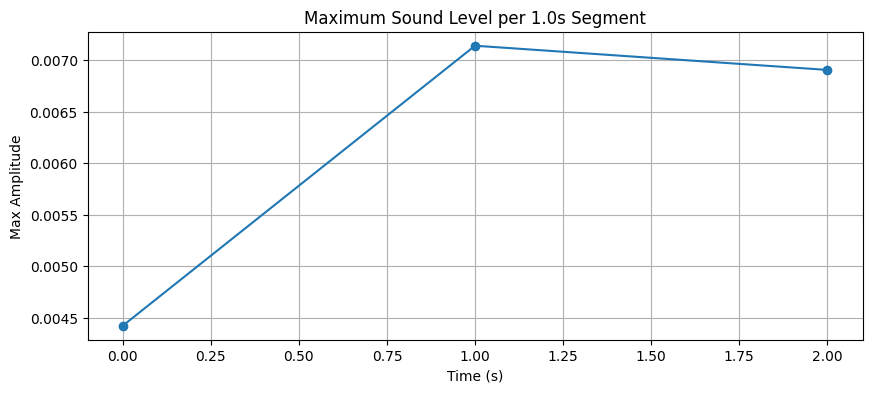

In [33]:
# plot the predictions versus gold
# print(np.shape(predictions))
# y_pred_1d = [p for p in predictions]
# print(np.shape(y_pred_1d[0]))

model.eval()
with torch.no_grad():
    y_out = model(x_tensor).detach()
# y_out = y_out + x_tensor
print(y_gold.shape)
print(y_out.squeeze().unsqueeze(0).shape)
print("Gold audio")
display(Audio(y_gold.squeeze().cpu().numpy(), rate=sample_rate))
viz_tensor_audio(y_gold)
print("Output audio")
display(Audio(y_out.squeeze().cpu().numpy(), rate=sample_rate))
viz_tensor_audio(y_out.squeeze().unsqueeze(0), interval=1.0, sample_rate=sample_rate)


In [34]:
# Let's compute error to signal ratio for the trained model
if device.type == 'cuda':
    y_gold_1d = y_gold.cpu().squeeze().numpy()
    y_out_1d = y_out.cpu().squeeze().numpy()
else:   
    y_gold_1d = y_gold.squeeze().numpy()
    y_out_1d = y_out.squeeze().numpy()
print(np.shape(y_gold_1d))
print(np.shape(y_out_1d))
ESR = np.sum(np.abs(y_gold_1d - y_out_1d)**2) / np.sum(np.abs(y_gold_1d)**2)
print(f'Error to Signal Ratio: {ESR}')

(152345,)
(152345,)
Error to Signal Ratio: 1.001482367515564


In [35]:
print(predictions[0])
print(y_gold.squeeze().numpy())
print(predictions[0].shape)
print(NUM_EPOCHS // 10)


[-0.04299138 -0.02698833 -0.01495058 ... -0.28373545 -0.2809189
 -0.27849746]
[ 3.0517578e-04  1.8310547e-03  2.1362305e-03 ... -5.2185059e-01
 -5.2276611e-01 -5.2429199e-01]
(152345,)
100


[-0.04299138 -0.02698833 -0.01495058 ... -0.28373545 -0.2809189
 -0.27849746]
(100, 152345)


Output audio


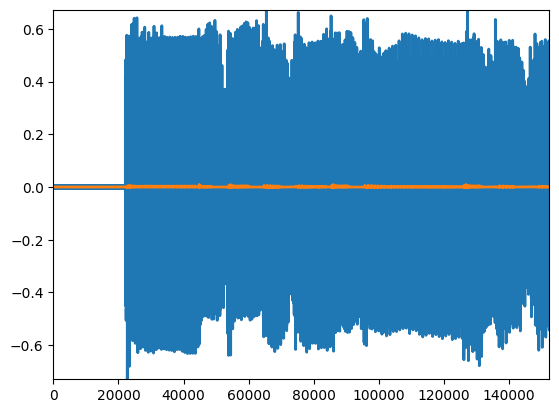

In [36]:
# %matplotlib 

y_gold_numpy = y_gold.squeeze().cpu().numpy()
y_pred_1d = [p for p in predictions[::10]]  
print(y_pred_1d[0])
print(np.shape(y_pred_1d)) 
y_range = range(len(y_gold_numpy))
fig, ax = plt.subplots()
ax.set_xlim(0, len(y_gold_numpy))
ax.set_ylim(min(y_gold_numpy), max(y_gold_numpy ))

# Plot y_gold
y_gold_line, = ax.plot([], [], label='y_gold', lw=2)
y_gold_line.set_data(y_range, y_gold_numpy)

# Initialize an empty line for the predictions
y_pred_line, = ax.plot([], [], label='y_pred', lw=2)

def init():
    y_pred_line.set_data([], [])
    return y_gold_line, y_pred_line

def update(frame):
    # Update the data for the y_pred_line
    y_pred_line.set_data(y_range, y_pred_1d[frame])
    return y_gold_line, y_pred_line

ani = FuncAnimation(fig, update, frames=range(len(y_pred_1d)), 
                    init_func=init, blit=True, repeat=False, interval=100)
display(HTML(ani.to_html5_video()))
print("Output audio")


In [26]:
ani.save('lstm_torch_real.mp4', writer='ffmpeg', fps=10)

# ax.legend()
# plt.show()

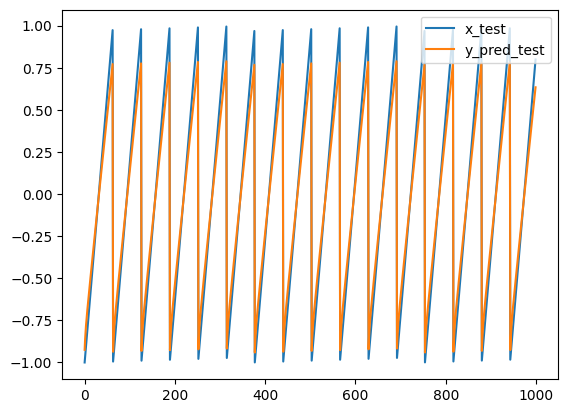

In [93]:
# how about a sawtooth?
x_test = signal.sawtooth(np.arange(0, 100, 0.1))
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

model.eval()
with torch.no_grad():
    y_pred_test = model(x_test_tensor).detach().numpy().squeeze()
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
y_pred_test = model(x_test_tensor).detach().numpy().squeeze()
fig, ax = plt.subplots()
plt.plot(x_test)
plt.plot(y_pred_test)
plt.legend(['x_test', 'y_pred_test'])

plt.show()